Let $G_n$ be the set of graphs with vertex set $V = \{1 ... n \}$

Colouring of a graph $G \in G_n$ is a function $\pi : V \rightarrow \{1 ... k  \}$  for some number of colours $k = |\pi|$.

A cell of $\pi$ is a set of vertices with a given colour, $\pi^{-1}(j)$. A discrete colouring, where every vertex has a unique colour, is a permutation of the set $V$. 

For two colourings $\pi$ and $\pi^\prime$, $\pi^\prime \le \pi$ if $\pi(v) < \pi(w) \implies \pi^\prime(v) < \pi^\prime(w)$. This means that each cell of $\pi^\prime$ is a subset of a cell of $\pi$. 

A coloured graph is a pair $(G, \pi)$

We want to define a canonical form of a graph such that all graphs within an isomorphism class map to the same canonical form.

1. $C((G, \pi)) \cong (G, \pi)$
2. $C((G^g, \pi^g)) = C((G, \pi))$ where $(G^g, \pi^g)$ is a permutation of the coloured graph $(G, \pi)$. (A permutation is the action of an element $g \in S_n$ where $S_n$ is the finite symmetric group over $n$ symbols.

# A direct string diagram representation

String diagrams feature _wires_ and _boxes_

Open string diagrams have open ends to wires for inputs and outputs. 

Wires connect one output port to one input port.
Boxes can have any number of inputs and outputs. 

Wires are nodes in hypergraphs, and boxes are hyperegdes. 
Hypergraphs can be used directly or can be converted into bipartite graphs, amongst other representations. 

In [16]:
from graphviz import Digraph
from typing import NamedTuple

In [17]:
class Wire:
    """
    A wire connects either an input or a box to either a box or an output.
    """
    def __init__(self, s, t, d):
        self.source = s
        self.target = t
        self.dtype = d

class Box:
    def __init__(self, d, l):
        self.inputs: list[int] = []
        self.outputs: list[int] = []
        self.dtype: tuple[str, str] = d
        self.label: str = l

class OpenEnd:
    def __init__(self, s):
        self.dtype = s

class Diagram:
    def __init__(self):
        self.graphRep = Digraph()
        self.grNodeCount = 0

        self.inputWires: list[Wire] = []
        self.outputWires: list[Wire] = []
        self.wires: list[Wire] = []
        self.boxes: list[Box] = []
        self.inputs: list[OpenEnd] = [] 
        self.outputs: list[OpenEnd] = []
        self.inputTypes: dict[str, int] = {}
        self.outputTypes: dict[str, int] = {}

    def addBox(self, b):
        self.boxes.append(b)
        self.graphRep.node("b" + str(len(self.boxes)-1) + "; " + b.label)

    def addInput(self, i):
        self.inputs.append(i)
        if i.dtype in self.inputTypes.keys():
            self.inputTypes[i.dtype] += 1
        else:
            self.inputTypes[i.dtype] = 1
        self.graphRep.node("i" + str(len(self.inputs)-1) + "; " + i.dtype)

    def addOutput(self, o):
        self.outputs.append(o)
        if o.dtype in self.outputTypes.keys():
            self.outputTypes[o.dtype] += 1
        else:
            self.outputTypes[o.dtype] = 1
        self.graphRep.node("o" + str(len(self.outputs)-1) + "; "+ o.dtype)
    
    def addInputWire(self, w):
        self.inputWires.append(w)
        self.graphRep.edge("i" + str(w.source) + "; " + w.dtype, "b" + str(w.target) + "; " + self.boxes[w.target].label)

    def addWire(self, w):
        self.wires.append(w)

    def addOutputWire(self, w):
        self.outputWires.append(w)

    def drawGraph(self):
        self.graphRep.render

In [18]:
i0 = OpenEnd("A")
i1 = OpenEnd("A")
i2 = OpenEnd("B")
o0 = OpenEnd("A")
o1 = OpenEnd("B")

b0 = Box(("A", "A"), "f")

D = Diagram()
D.addInput(i0)
D.addInput(i1)
D.addInput(i2)
D.addOutput(o0)
D.addBox(b0)
D.addInputWire(Wire(0, 0, "A"))

D2 = Diagram()
D2.addInput(i0)
D2.addInput(i1)
D2.addInput(i2)
D2.addOutput(o0)

print(D.inputTypes, D2.inputTypes)

{'A': 2, 'B': 1} {'A': 2, 'B': 1}


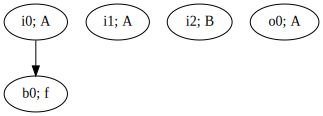

In [19]:
D.graphRep

In [6]:
def CompareDiagrams(D1, D2):
    """Compare Two String Diagrams"""

    # Compare inputs and outputs
    input_check = D1.inputTypes == D2.inputTypes
    output_check = D1.outputTypes == D2.outputTypes
    if (not input_check) or (not output_check):
        return False

    # 
    
    return True

print(CompareDiagrams(D, D2))

True


# Hyper graph representation

Old terms:

Wire = Node

Box = Edge

Question:

HypEdge = Function = Box ?

`Input` is a `Node` with no `prev`
`Output` is a `Node` with no `next`


`next` and `prev` are members of the `Node` class

In the diagram 
- `next` the arrows from node to edge
- `prev` the arrows edge to node 

Assumption:

HypEdge are same if the source and targets have the same signatures

`Signature` is a list of indices which in turn correspond to `labels` of `Nodes` (str)

Assuming to be true

In [21]:
class Node: # Drawn as Circle
    def __init__(self, t: str, prev: int | None = None, next: int | None = None):
        self.label = t
        # Arindam: self.prev is a list of box indices
        self.prev: int | None = prev
        self.next: int | None = next


class Signature(NamedTuple):
    sources: list[Node]
    targets: list[Node]

class HyperEdge: # Drawn as Box
    def __init__(self, sources: list[Node], targets: list[Node], label: str):
        self.sources = sources
        self.targets = targets
        self.label = label

    @property
    def signature(self) -> Signature:
        return Signature(
            sources=[self.sources[i] for i in range(len(self.sources))],
            targets=[self.targets[i] for i in range(len(self.targets))]
        )

class OpenHGraph:
    def __init__(self):
        self.inputs: list[Node] = []
        self.outputs: list[Node] = []
        self.nodes: list[Node] = []
        self.hyperEdges: list[HyperEdge] = []


        # TODO: Checks for inputs and outputs
        # `Input` is a `Node` with no `prev`
        # `Output` is a `Node` with no `next`


    def addHyperEdge(self, sources: list[Node], targets: list[Node], label: str):
        self.hyperEdges.append(HyperEdge(sources, targets, label))


    def drawGraph(self):

        @staticmethod
        def nodeLabel(label: str, index: int):
            return label + "; " + str(index)

        def drawArrows(hyperEdge: HyperEdge, edge_label: str):

            # Draw arrows from nodes to edges
            for s in hyperEdge.sources:
                self.graphRep.edge(nodeLabel(s.label, self.nodes.index(s)), edge_label)

            # Draw arrows from edges to nodes
            for t in hyperEdge.targets:
                self.graphRep.edge(edge_label, nodeLabel(t.label, self.nodes.index(t)))

        self.graphRep = Digraph()
        
        for node in self.nodes:
            node_label = nodeLabel(node.label, self.nodes.index(node))
            self.graphRep.node(node_label, shape='circle')

        for hyperEdge in self.hyperEdges:
            edge_label = hyperEdge.label + ", " + str(self.hyperEdges.index(hyperEdge))
            self.graphRep.node(edge_label, shape='box')

            drawArrows(hyperEdge, edge_label)

        return self.graphRep

class Label:
    def __init__(self):
        self.type = ""
        self.prequel = ""
        self.sequel = ""
        self.depth = 0
        self.io = -1
    
    def __str__(self):
        return (f"Label(type='{self.type}', prequel='{self.prequel}', "
                f"sequel='{self.sequel}', depth={self.depth}, io={self.io})")


In [22]:
SD = OpenHGraph()
SD.nodes = [Node("A"), Node("A"), Node("B"), Node("A"), Node("B"), Node("A"), Node("B"), Node("B"), Node("A"), Node("A"), Node("B"), Node("B"), Node("B"), Node("B")]
# SD.inputs = [0,1,2,3]
SD.inputs = [SD.nodes[0], SD.nodes[1], SD.nodes[2], SD.nodes[3]]
SD.outputs = [SD.nodes[11], SD.nodes[12], SD.nodes[13]]

SD.addHyperEdge([SD.nodes[0]], [SD.nodes[4], SD.nodes[5]], "f")
SD.addHyperEdge([SD.nodes[1], SD.nodes[2]], [SD.nodes[6]], "g")
SD.addHyperEdge([SD.nodes[3]], [SD.nodes[7], SD.nodes[8]], "f")
SD.addHyperEdge([SD.nodes[4]], [SD.nodes[11], SD.nodes[9]], "f")
SD.addHyperEdge([SD.nodes[5], SD.nodes[6]], [SD.nodes[10]], "g")
SD.addHyperEdge([SD.nodes[7], SD.nodes[8]], [SD.nodes[13]], "g")
SD.addHyperEdge([SD.nodes[9], SD.nodes[10]], [SD.nodes[12]], "g")

## Ordered colouring on Hypergraph Nodes

Assume that _types_ (wires) and _labels_ (boxes) can be ordered. 

Define a colouring $\pi(v)$, typing $T(v)$

The following properties of the hypergraph must be preserved by isomorphism and therefore respected by the colouring:

- Input and Output Nodes: $v_1 \in$ Input, $v_2 \in$ Internal, $v_3 \in$ Output $\implies \pi(v_1) < \pi(v_2) < \pi(v_3)$
    - case: what if a node is an input and an output node 
- Type: $T(v_1) < T(v_2) \implies \pi(v_1) < \pi(v_2)$
- Input Connectivity: for $v_1 \in I(b_1)$, $v_2 \in I(b_2)$, $L(b_1) < L(b_2) \implies \pi(v_1) < \pi(v_2)$
- Output Connectivity: for $v_1 \in O(b_1)$, $v_2 \in O(b_2)$, $L(b_1) < L(b_2) \implies \pi(v_1) < \pi(v_2)$
- Input Port Order: for $v_1, v_2 \in I(b)$, $p_b(v_1) < p_i,b(v_2) \implies \pi(v_1) < \pi(v_2)$
- Output Port Order: for $v_1, v_2 \in O(b)$, $p_b(v_1) < p_o,b(v_2) \implies \pi(v_1) < \pi(v_2)$

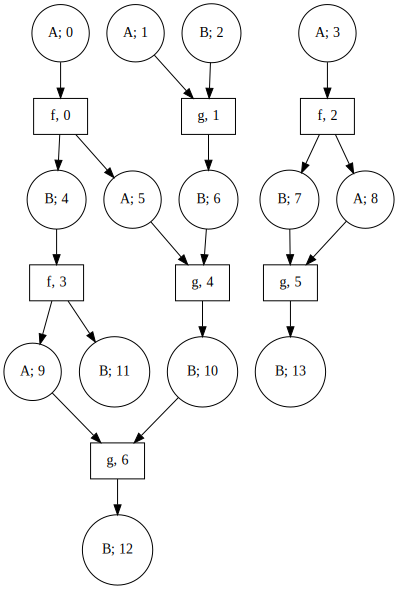

In [23]:
g = SD.drawGraph()
g

If there are no cycles, we can look at the order of operations unambiguously

- Order of operations: $v_1 \in I(b), v_2 \in O(b) \implies \pi(v_1) < \pi(v_2)$

**Important: each input / output maps to a known ordered node. This means that we can distinguish input and output nodes unambiguously which will allow us to improve this procedure considerably. This may allow us to follow from the input to output in a more straightforward way.**

Consider e.g. a depth first exploration which equates nodes between two graphs as we go along:

- Find input 1 in both graphs.
- In both graphs, find the box $b$ that input 1 connects to. These boxes are identified.
- For each ordered output of $b$, identify the nodes in each graph with one another unless there is a conflict.
- Continue for the full graph for all inputs. If no conflicts, these graphs should be the same! 

- We can for now assume the _cartesian_ property that all disconnected sub-diagrams can be deleted. 

In [200]:
def ColourDiagram(SD):
    colouring = {}  # map from vertices to colours
    cells = {}      # map from colours to sets of vertices
    # if all cells are singletons then the graph has been fully partitioned

    def setCells():
        cells.clear()
        for i in range(len(SD.wires)):
            label = str(colouring[i])
            print(label)
            if label in cells:
                cells[label].append(i)
            else:
                cells[label] = [i]
    
    # colour based on input / output / internal and type
    for v in range(len(SD.wires)):
        colouring[v] = Label()
        colouring[v].type = SD.wires[v].dtype
        if v in SD.inputs:
            colouring[v].io = 0
        elif v in SD.outputs:
            colouring[v].io = 2
        else:
            colouring[v].io = 1

    # start adding in hyperedges
    for b in SD.boxes:
        # update colouring with edge labels
        # monogamous acyclic => only one hyperedge per wire
        port = 0
        box_depth = 0
        for s in b.sources:
            colouring[s].sequel = b.label + str(port)
            port += 1
            box_depth = max(colouring[s].depth + 1, box_depth)
        port = 0
        for t in b.targets:
            colouring[t].prequel = b.label + str(port)
            colouring[t].depth = max(box_depth, colouring[t].depth)

    setCells();

    def discreteColouring():
        setCells();
        for(l, ws) in cells.items():
            if (len(ws) > 1):
                return False
        return True

    while not discreteColouring():
        for (l, ws) in cells.items():
            if (len(ws) > 1):
                # Try to distinguish between cells which are current labelled the same
                # e.g. follow chain of computation forward or backward until a distinction is made
                w0, w1 = ws[0], ws[1]
                chain0 = colouring[w0].sequel
                chain1 = colouring[w1].sequel

                # identify the next morphism; these must be the same type
                m0 = SD.boxes[SD.wires[w0].next]
                m1 = SD.boxes[SD.wires[w1].next]
                
                def chainNext(m0, m1, chain0, chain1):
                    num_t = len(m0.targets)
                    for t in range(num_t):
                        m0_next = SD.boxes[SD.wires[m0.targets[t]].next]
                        m1_next = SD.boxes[SD.wires[m1.targets[t]].next]
                        chain0 = chain0 + m0_next.label
                        chain1 = chain1 + m1_next.label
                        if(chain0 != chain1):
                            break
                        else:
                            chainNext(m0_next, m1_next, chain0, chain1)
                    return chain0, chain1

                chain0, chain1 = chainNext(m0, m1)
                colouring[w0].sequel = chain0
                colouring[w1].sequel = chain1
    
    return colouring, cells
            
     

In [201]:
pi, c = ColourDiagram(SD)

In [202]:
for (x, k) in pi.items():
    print(x, k)

0 Label(type='A', prequel='', sequel='f0f', depth=0, io=0)
1 Label(type='A', prequel='', sequel='g0', depth=0, io=0)
2 Label(type='B', prequel='', sequel='g1', depth=0, io=0)
3 Label(type='A', prequel='', sequel='f0g', depth=0, io=0)
4 Label(type='B', prequel='f0', sequel='f0', depth=1, io=1)
5 Label(type='A', prequel='f0', sequel='g0', depth=1, io=1)
6 Label(type='B', prequel='g0', sequel='g1', depth=1, io=1)
7 Label(type='B', prequel='f0', sequel='g0', depth=1, io=1)
8 Label(type='A', prequel='f0', sequel='g1', depth=1, io=1)
9 Label(type='A', prequel='f0', sequel='g0', depth=2, io=1)
10 Label(type='B', prequel='g0', sequel='g1', depth=2, io=1)
11 Label(type='B', prequel='f0', sequel='', depth=2, io=2)
12 Label(type='B', prequel='g0', sequel='', depth=3, io=2)
13 Label(type='B', prequel='g0', sequel='', depth=2, io=2)


In [199]:
for (k, x) in c.items():
    if (len(x) > 1):
        print(k, x)